In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
import itertools

import statsmodels as sm
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf 
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_process import arma_generate_sample

from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from pmdarima import model_selection

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.preprocessing import OneHotEncoder

In [3]:
data = pd.read_csv('./data/zillow_data.csv')

In [4]:
df_weekly = pd.read_csv('./data/zillow_weekly_data.csv')

In [5]:
def melt_data_weekly(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [6]:
weekly_melt =  melt_data_weekly(df_weekly)
weekly_melt.set_index('time', inplace = True)
weekly_melt.index = pd.to_datetime(weekly_melt.index)
weekly_melt.rename(columns = {'value':'Price'}, inplace = True)

In [7]:
weekly_melt

,RegionID,SizeRank,RegionName,RegionType,StateName,Price
time,,,,,,
2008-02-02,102001,0,United States,country,NaN,184169.0
2008-02-02,394913,1,"New York, NY",msa,NY,392000.0
2008-02-02,753899,2,"Los Angeles, CA",msa,CA,475000.0
2008-02-02,394463,3,"Chicago, IL",msa,IL,239500.0
2008-02-02,394514,4,"Dallas, TX",msa,TX,137550.0
...,...,...,...,...,...,...
2023-06-03,394917,282,"Niles, MI",msa,MI,339500.0
2023-06-03,394685,289,"Homosassa Springs, FL",msa,FL,266150.0
2023-06-03,394442,321,"Carbondale, IL",msa,IL,132950.0


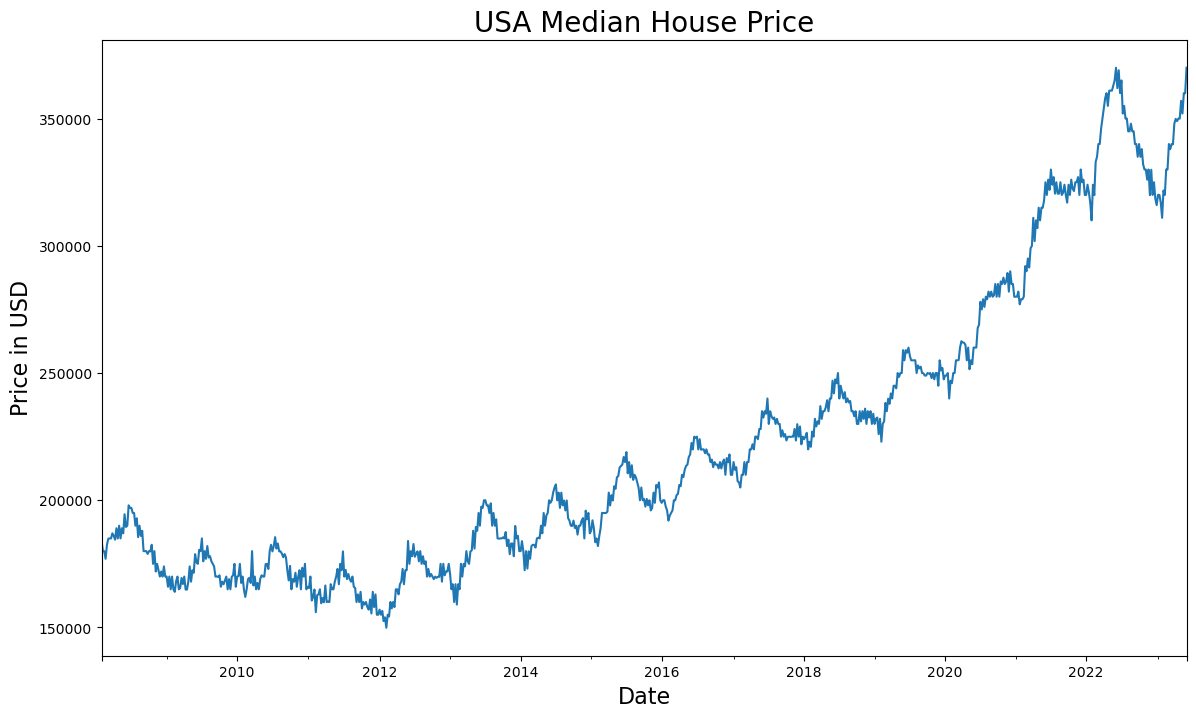

In [8]:
fig, ax = plt.subplots(figsize = (14,8))

weekly_melt[weekly_melt['RegionName'] == 'United States']['Price'].plot(ax = ax)

ax.set_title('USA Median House Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

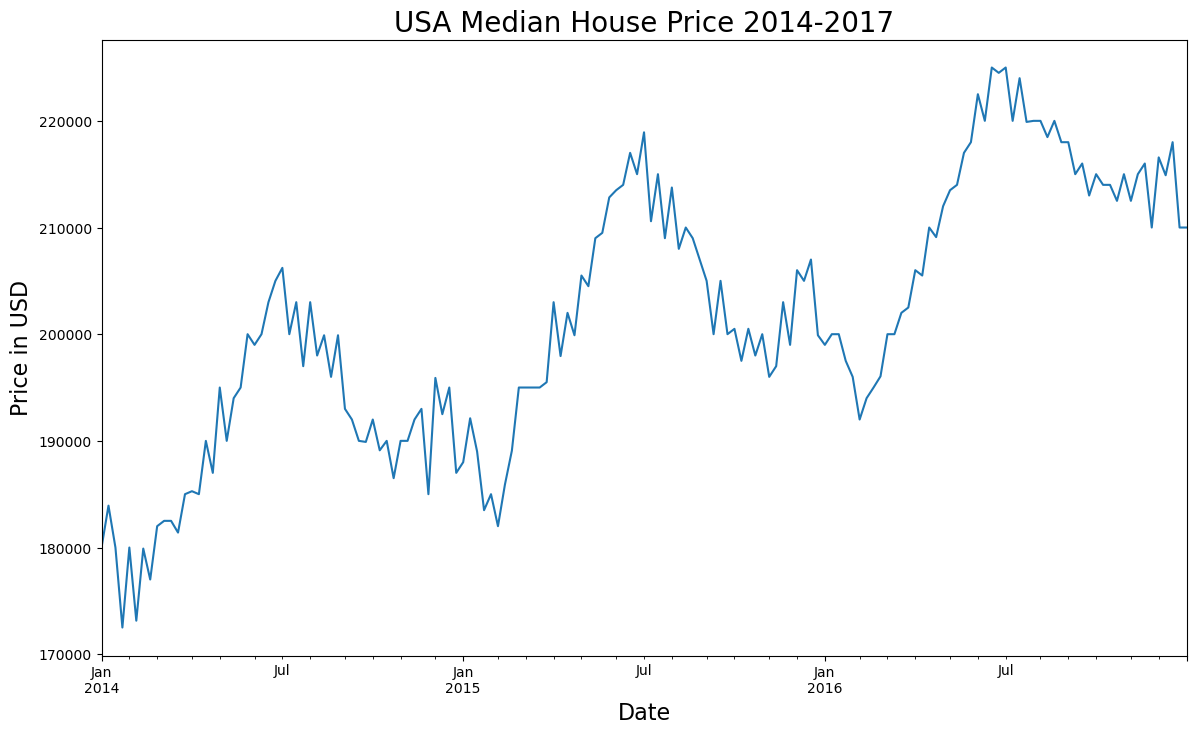

In [9]:
fig, ax = plt.subplots(figsize = (14,8))

weekly_melt[weekly_melt['RegionName'] == 'United States']['2014':'2016']['Price'].plot(ax = ax)

ax.set_title('USA Median House Price 2014-2017', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

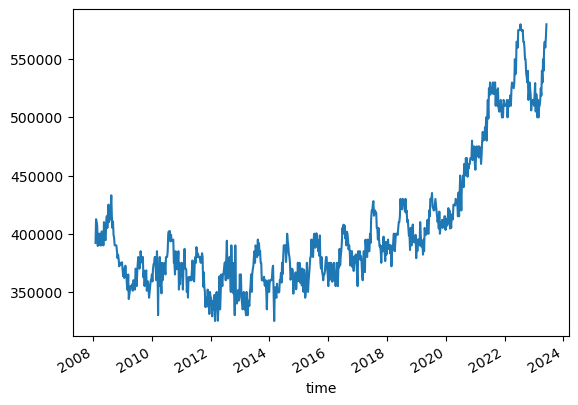

In [10]:
weekly_melt[weekly_melt['RegionName'] == 'New York, NY']['Price'].plot();

In [11]:
weekly_melt['StateName'].unique()

array([nan, 'NY', 'CA', 'IL', 'TX', 'VA', 'PA', 'FL', 'GA', 'MA', 'AZ',
       'MI', 'MN', 'CO', 'MD', 'MO', 'NC', 'OR', 'OH', 'NV', 'IN', 'TN',
       'RI', 'WI', 'OK', 'KY', 'UT', 'CT', 'AL', 'HI', 'NE', 'SC', 'NM',
       'ID', 'AR', 'MS', 'ME', 'LA', 'DE', 'WA', 'NJ'], dtype=object)

In [12]:
weekly_melt

,RegionID,SizeRank,RegionName,RegionType,StateName,Price
time,,,,,,
2008-02-02,102001,0,United States,country,NaN,184169.0
2008-02-02,394913,1,"New York, NY",msa,NY,392000.0
2008-02-02,753899,2,"Los Angeles, CA",msa,CA,475000.0
2008-02-02,394463,3,"Chicago, IL",msa,IL,239500.0
2008-02-02,394514,4,"Dallas, TX",msa,TX,137550.0
...,...,...,...,...,...,...
2023-06-03,394917,282,"Niles, MI",msa,MI,339500.0
2023-06-03,394685,289,"Homosassa Springs, FL",msa,FL,266150.0
2023-06-03,394442,321,"Carbondale, IL",msa,IL,132950.0


In [13]:
def date_features(df):
    """
    Data features for time series analysis
    """
    df = df.copy()
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear

    return df

In [14]:
nyc = weekly_melt[weekly_melt['RegionName'] == 'New York, NY']

In [ ]:
nyc

In [ ]:
nyc = date_features(nyc)

In [ ]:
nyc.columns

In [23]:
features = ['year', 'quarter', 'month', 'dayofyear']

In [ ]:
nyc_train = nyc.loc[nyc.index < '2019-01-01']
nyc_test = nyc.loc[(nyc.index >= '2019-01-01')]# & (nyc.index < '2020-01-01')]

In [ ]:
X_train_nyc = nyc_train[features]
y_train_nyc = nyc_train['Price']

X_test_nyc = nyc_test[features]
y_test_nyc = nyc_test['Price']

In [ ]:
reg_2 = xgb.XGBRegressor(n_estimators=1000, learning_rate = .05)
reg_2.fit(X_train_nyc, y_train_nyc,
        eval_set=[(X_train_nyc, y_train_nyc), (X_test_nyc, y_test_nyc)],
        early_stopping_rounds=100,
       verbose=True)

In [ ]:
nyc_train['Predicted'] = reg_2.predict(X_train_nyc)
nyc_test['Predicted'] = reg_2.predict(X_test_nyc)

In [ ]:
fig, ax = plt.subplots(figsize = (14,8))

nyc_train['Price'].plot(color = 'blue')
nyc_train['Predicted'].plot(color = 'purple')

nyc_test['Price'].plot(color = 'blue')
nyc_test['Predicted'].plot(color = 'red')


ax.set_title('NYC Median House  Sale Price vs. Model Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

In [ ]:
nyc_train = nyc.loc[nyc.index < '2020-01-01']
nyc_test = nyc.loc[(nyc.index >= '2020-01-01')]

In [ ]:
nash = weekly_melt[weekly_melt['RegionName'] == 'Nashville, TN']

In [ ]:
nash = date_features(nash)

In [ ]:
nash_train = nash.loc[nash.index < '2021-01-01']
nash_test = nash.loc[(nash.index >= '2021-01-01')]

In [ ]:
X_train_nash = nash_train[features]
y_train_nash = nash_train['Price']

X_test_nash = nash_test[features]
y_test_nash = nash_test['Price']

In [ ]:
reg_nash = xgb.XGBRegressor(n_estimators=1000, learning_rate = .01)
reg_nash.fit(X_train_nash, y_train_nash,
        eval_set=[(X_train_nash, y_train_nash), (X_test_nash, y_test_nash)],
        early_stopping_rounds=100,
       verbose=True)

In [ ]:
nash_train['Predicted'] = reg_nash.predict(X_train_nash)
nash_test['Predicted'] = reg_nash.predict(X_test_nash)

In [ ]:
fig, ax = plt.subplots(figsize = (14,8))

nash_train['Price'].plot(color = 'blue')
nash_train['Predicted'].plot(color = 'purple')

nash_test['Price'].plot(color = 'blue')
nash_test['Predicted'].plot(color = 'red')


ax.set_title('Nashville Median House Sale Price vs. Model Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

In [ ]:
nash_train = nash.loc[nash.index < '2018-01-01']
nash_test = nash.loc[(nash.index >= '2018-01-01') & (nash.index < '2020-01-01')]

In [ ]:
X_train_nash = nash_train[features]
y_train_nash = nash_train['Price']

X_test_nash = nash_test[features]
y_test_nash = nash_test['Price']

In [ ]:
reg_nash = xgb.XGBRegressor(n_estimators=1000, learning_rate = .01)
reg_nash.fit(X_train_nash, y_train_nash,
        eval_set=[(X_train_nash, y_train_nash), (X_test_nash, y_test_nash)],
        early_stopping_rounds=100,
       verbose=True)

In [ ]:
nash_train['Predicted'] = reg_nash.predict(X_train_nash)
nash_test['Predicted'] = reg_nash.predict(X_test_nash)

In [ ]:
fig, ax = plt.subplots(figsize = (14,8))

nash_train['Price'].plot(color = 'blue')
nash_train['Predicted'].plot(color = 'purple')

nash_test['Price'].plot(color = 'blue')
nash_test['Predicted'].plot(color = 'red')


ax.set_title('Nashville Median House Sale Price vs. Model Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

In [15]:
weekly_melt

,RegionID,SizeRank,RegionName,RegionType,StateName,Price
time,,,,,,
2008-02-02,102001,0,United States,country,NaN,184169.0
2008-02-02,394913,1,"New York, NY",msa,NY,392000.0
2008-02-02,753899,2,"Los Angeles, CA",msa,CA,475000.0
2008-02-02,394463,3,"Chicago, IL",msa,IL,239500.0
2008-02-02,394514,4,"Dallas, TX",msa,TX,137550.0
...,...,...,...,...,...,...
2023-06-03,394917,282,"Niles, MI",msa,MI,339500.0
2023-06-03,394685,289,"Homosassa Springs, FL",msa,FL,266150.0
2023-06-03,394442,321,"Carbondale, IL",msa,IL,132950.0


In [16]:
indy = weekly_melt[weekly_melt['RegionName'] == 'Indianapolis, IN']

In [17]:
indy

,RegionID,SizeRank,RegionName,RegionType,StateName,Price
time,,,,,,
2008-02-02,394705,34,"Indianapolis, IN",msa,IN,113001.0
2008-02-09,394705,34,"Indianapolis, IN",msa,IN,119000.0
2008-02-16,394705,34,"Indianapolis, IN",msa,IN,111950.0
2008-02-23,394705,34,"Indianapolis, IN",msa,IN,102750.0
2008-03-01,394705,34,"Indianapolis, IN",msa,IN,120500.0
...,...,...,...,...,...,...
2023-05-06,394705,34,"Indianapolis, IN",msa,IN,284000.0
2023-05-13,394705,34,"Indianapolis, IN",msa,IN,262750.0
2023-05-20,394705,34,"Indianapolis, IN",msa,IN,278250.0


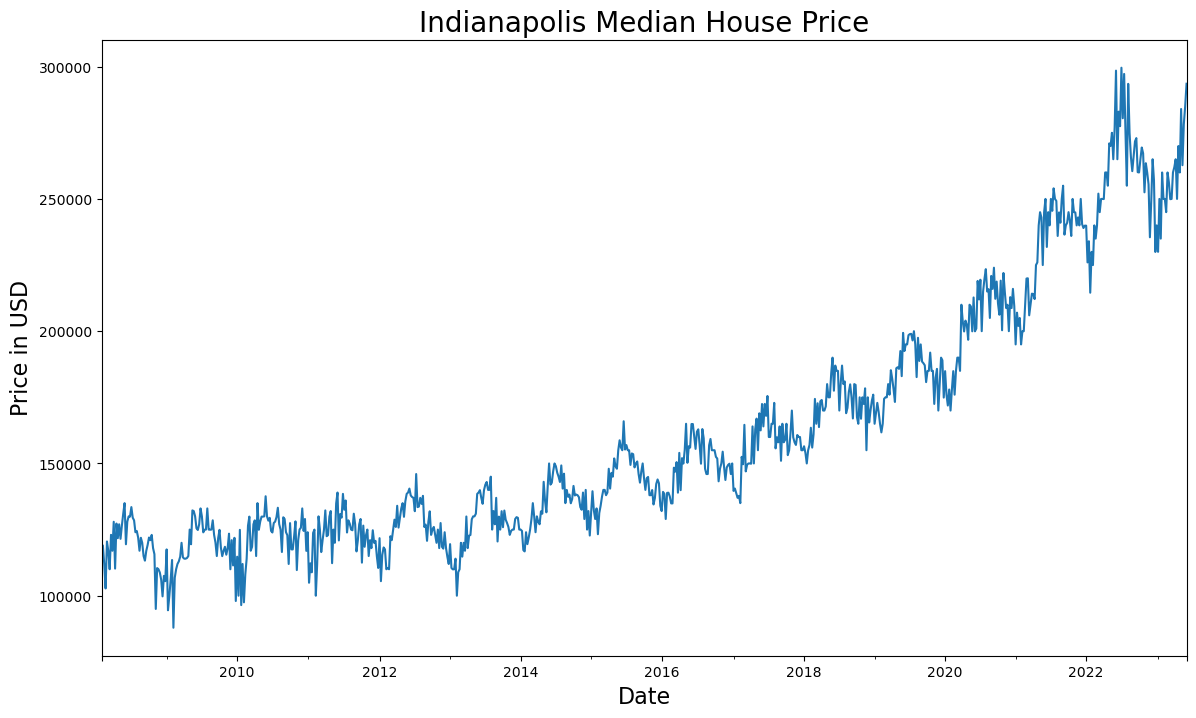

In [18]:
fig, ax = plt.subplots(figsize = (14,8))

indy['Price'].plot(ax = ax)

ax.set_title('Indianapolis Median House Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

In [24]:
indy = date_features(indy)

In [25]:
indy_train = indy.loc[indy.index < '2021-01-01']
indy_test = indy.loc[(indy.index >= '2021-01-01')]

In [26]:
X_train_indy = indy_train[features]
y_train_indy = indy_train['Price']

X_test_indy = indy_test[features]
y_test_indy = indy_test['Price']

In [27]:
reg_indy = xgb.XGBRegressor(n_estimators=1000, learning_rate = .01)
reg_indy.fit(X_train_indy, y_train_indy,
        eval_set=[(X_train_indy, y_train_indy), (X_test_indy, y_test_indy)],
        early_stopping_rounds=100,
       verbose=True)

[0]	validation_0-rmse:146102.94255	validation_1-rmse:247207.76385
[1]	validation_0-rmse:144660.83865	validation_1-rmse:245315.47159
[2]	validation_0-rmse:143233.14421	validation_1-rmse:243442.03694
[3]	validation_0-rmse:141819.72068	validation_1-rmse:241587.26414
[4]	validation_0-rmse:140420.42439	validation_1-rmse:239750.99609
[5]	validation_0-rmse:139035.11883	validation_1-rmse:237933.02733
[6]	validation_0-rmse:137663.66981	validation_1-rmse:236133.19388
[7]	validation_0-rmse:136305.93224	validation_1-rmse:234351.29710
[8]	validation_0-rmse:134961.77447	validation_1-rmse:232587.17302
[9]	validation_0-rmse:133631.06502	validation_1-rmse:230840.65287
[10]	validation_0-rmse:132313.66933	validation_1-rmse:229111.55179
[11]	validation_0-rmse:131009.45276	validation_1-rmse:227399.69314
[12]	validation_0-rmse:129718.28687	validation_1-rmse:225704.90827
[13]	validation_0-rmse:128440.04512	validation_1-rmse:224027.03884
[14]	validation_0-rmse:127174.60021	validation_1-rmse:222365.89923
[15]	

[124]	validation_0-rmse:43216.14625	validation_1-rmse:109095.59575
[125]	validation_0-rmse:42799.69207	validation_1-rmse:108513.39397
[126]	validation_0-rmse:42387.31137	validation_1-rmse:107931.86776
[127]	validation_0-rmse:41978.98746	validation_1-rmse:107394.89187
[128]	validation_0-rmse:41574.83404	validation_1-rmse:106827.13068
[129]	validation_0-rmse:41174.93544	validation_1-rmse:106275.25665
[130]	validation_0-rmse:40778.74814	validation_1-rmse:105753.91636
[131]	validation_0-rmse:40386.65540	validation_1-rmse:105212.66487
[132]	validation_0-rmse:39998.40527	validation_1-rmse:104666.49810
[133]	validation_0-rmse:39614.02247	validation_1-rmse:104123.20452
[134]	validation_0-rmse:39233.17097	validation_1-rmse:103583.54177
[135]	validation_0-rmse:38856.55889	validation_1-rmse:103063.39932
[136]	validation_0-rmse:38483.60555	validation_1-rmse:102538.44440
[137]	validation_0-rmse:38114.58419	validation_1-rmse:102028.79291
[138]	validation_0-rmse:37749.20715	validation_1-rmse:101546.8

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[162]	validation_0-rmse:29997.18543	validation_1-rmse:90761.50498
[163]	validation_0-rmse:29712.93048	validation_1-rmse:90367.37869
[164]	validation_0-rmse:29431.86989	validation_1-rmse:89966.79648
[165]	validation_0-rmse:29153.58109	validation_1-rmse:89597.41078
[166]	validation_0-rmse:28878.11594	validation_1-rmse:89205.67268
[167]	validation_0-rmse:28605.40966	validation_1-rmse:88817.82313
[168]	validation_0-rmse:28335.58549	validation_1-rmse:88442.79933
[169]	validation_0-rmse:28068.32216	validation_1-rmse:88088.14977
[170]	validation_0-rmse:27803.70748	validation_1-rmse:87708.48043
[171]	validation_0-rmse:27541.54105	validation_1-rmse:87332.58234
[172]	validation_0-rmse:27282.09931	validation_1-rmse:86972.08845
[173]	validation_0-rmse:27025.22516	validation_1-rmse:86615.19559
[174]	validation_0-rmse:26771.22660	validation_1-rmse:86277.55065
[175]	validation_0-rmse:26519.82901	validation_1-rmse:85915.94529
[176]	validation_0-rmse:26270.72373	validation_1-rmse:85569.42743
[177]	vali

[287]	validation_0-rmse:9926.76462	validation_1-rmse:62325.52881
[288]	validation_0-rmse:9850.31542	validation_1-rmse:62217.49224
[289]	validation_0-rmse:9775.04985	validation_1-rmse:62110.51899
[290]	validation_0-rmse:9700.65442	validation_1-rmse:61996.19974
[291]	validation_0-rmse:9627.03257	validation_1-rmse:61891.15707
[292]	validation_0-rmse:9553.94738	validation_1-rmse:61778.98468
[293]	validation_0-rmse:9481.84999	validation_1-rmse:61676.03240
[294]	validation_0-rmse:9410.02637	validation_1-rmse:61573.97406
[295]	validation_0-rmse:9338.37575	validation_1-rmse:61464.89219
[296]	validation_0-rmse:9268.53857	validation_1-rmse:61364.89421
[297]	validation_0-rmse:9199.17368	validation_1-rmse:61265.76139
[298]	validation_0-rmse:9130.90298	validation_1-rmse:61159.67840
[299]	validation_0-rmse:9063.05024	validation_1-rmse:61062.43940
[300]	validation_0-rmse:8995.31952	validation_1-rmse:60958.34330
[301]	validation_0-rmse:8929.21647	validation_1-rmse:60863.06976
[302]	validation_0-rmse:8

[414]	validation_0-rmse:4838.23634	validation_1-rmse:54041.93267
[415]	validation_0-rmse:4821.63720	validation_1-rmse:54009.57917
[416]	validation_0-rmse:4804.91386	validation_1-rmse:53975.47881
[417]	validation_0-rmse:4788.69749	validation_1-rmse:53943.70573
[418]	validation_0-rmse:4773.04935	validation_1-rmse:53913.02617
[419]	validation_0-rmse:4757.63149	validation_1-rmse:53882.62931
[420]	validation_0-rmse:4741.77368	validation_1-rmse:53848.98227
[421]	validation_0-rmse:4725.34482	validation_1-rmse:53817.47420
[422]	validation_0-rmse:4710.19585	validation_1-rmse:53786.55186
[423]	validation_0-rmse:4695.15046	validation_1-rmse:53758.67225
[424]	validation_0-rmse:4680.63832	validation_1-rmse:53729.76438
[425]	validation_0-rmse:4666.05652	validation_1-rmse:53702.81893
[426]	validation_0-rmse:4651.86350	validation_1-rmse:53671.51087
[427]	validation_0-rmse:4636.33445	validation_1-rmse:53641.59045
[428]	validation_0-rmse:4622.23571	validation_1-rmse:53615.36169
[429]	validation_0-rmse:4

[541]	validation_0-rmse:3737.05218	validation_1-rmse:51538.04686
[542]	validation_0-rmse:3733.48280	validation_1-rmse:51526.87142
[543]	validation_0-rmse:3728.99000	validation_1-rmse:51515.92387
[544]	validation_0-rmse:3725.12841	validation_1-rmse:51505.04881
[545]	validation_0-rmse:3721.22602	validation_1-rmse:51494.90580
[546]	validation_0-rmse:3717.21311	validation_1-rmse:51484.30619
[547]	validation_0-rmse:3713.46498	validation_1-rmse:51475.05761
[548]	validation_0-rmse:3709.82277	validation_1-rmse:51465.68355
[549]	validation_0-rmse:3706.54848	validation_1-rmse:51455.90120
[550]	validation_0-rmse:3702.82857	validation_1-rmse:51445.58238
[551]	validation_0-rmse:3699.22783	validation_1-rmse:51435.38086
[552]	validation_0-rmse:3695.84864	validation_1-rmse:51425.86693
[553]	validation_0-rmse:3692.38469	validation_1-rmse:51416.94651
[554]	validation_0-rmse:3688.78593	validation_1-rmse:51406.96999
[555]	validation_0-rmse:3685.34665	validation_1-rmse:51398.79529
[556]	validation_0-rmse:3

[668]	validation_0-rmse:3394.39837	validation_1-rmse:50816.13906
[669]	validation_0-rmse:3392.41753	validation_1-rmse:50814.15157
[670]	validation_0-rmse:3390.14189	validation_1-rmse:50810.15134
[671]	validation_0-rmse:3388.62073	validation_1-rmse:50808.79287
[672]	validation_0-rmse:3386.55767	validation_1-rmse:50805.65802
[673]	validation_0-rmse:3384.30664	validation_1-rmse:50801.73272
[674]	validation_0-rmse:3382.27650	validation_1-rmse:50798.66339
[675]	validation_0-rmse:3380.83658	validation_1-rmse:50797.37376
[676]	validation_0-rmse:3378.06295	validation_1-rmse:50796.52859
[677]	validation_0-rmse:3375.66839	validation_1-rmse:50792.74581
[678]	validation_0-rmse:3373.63668	validation_1-rmse:50789.76850
[679]	validation_0-rmse:3371.70192	validation_1-rmse:50788.05634
[680]	validation_0-rmse:3370.29773	validation_1-rmse:50786.84658
[681]	validation_0-rmse:3368.09584	validation_1-rmse:50783.10142
[682]	validation_0-rmse:3366.10373	validation_1-rmse:50779.89307
[683]	validation_0-rmse:3

[795]	validation_0-rmse:3151.94448	validation_1-rmse:50610.38185
[796]	validation_0-rmse:3150.98712	validation_1-rmse:50610.17569
[797]	validation_0-rmse:3149.83754	validation_1-rmse:50608.91466
[798]	validation_0-rmse:3146.82524	validation_1-rmse:50608.73366
[799]	validation_0-rmse:3144.55066	validation_1-rmse:50606.32538
[800]	validation_0-rmse:3143.41460	validation_1-rmse:50605.21586
[801]	validation_0-rmse:3141.17696	validation_1-rmse:50602.76512
[802]	validation_0-rmse:3138.22355	validation_1-rmse:50602.59975
[803]	validation_0-rmse:3137.10035	validation_1-rmse:50601.38125
[804]	validation_0-rmse:3136.37893	validation_1-rmse:50600.54546
[805]	validation_0-rmse:3134.03919	validation_1-rmse:50598.57269
[806]	validation_0-rmse:3133.07916	validation_1-rmse:50597.41888
[807]	validation_0-rmse:3132.36834	validation_1-rmse:50596.59936
[808]	validation_0-rmse:3131.66825	validation_1-rmse:50595.79426
[809]	validation_0-rmse:3130.71859	validation_1-rmse:50594.52586
[810]	validation_0-rmse:3

[922]	validation_0-rmse:2965.47856	validation_1-rmse:50508.99955
[923]	validation_0-rmse:2963.68125	validation_1-rmse:50508.79256
[924]	validation_0-rmse:2961.74861	validation_1-rmse:50507.63032
[925]	validation_0-rmse:2959.54844	validation_1-rmse:50507.60607
[926]	validation_0-rmse:2958.71535	validation_1-rmse:50507.00945
[927]	validation_0-rmse:2956.96978	validation_1-rmse:50506.83075
[928]	validation_0-rmse:2956.25558	validation_1-rmse:50507.04867
[929]	validation_0-rmse:2954.18720	validation_1-rmse:50506.96577
[930]	validation_0-rmse:2952.36575	validation_1-rmse:50506.67057
[931]	validation_0-rmse:2951.56748	validation_1-rmse:50506.21732
[932]	validation_0-rmse:2950.86429	validation_1-rmse:50506.44574
[933]	validation_0-rmse:2948.64806	validation_1-rmse:50506.15283
[934]	validation_0-rmse:2947.26464	validation_1-rmse:50506.57584
[935]	validation_0-rmse:2944.89145	validation_1-rmse:50505.11335
[936]	validation_0-rmse:2942.53311	validation_1-rmse:50505.69266
[937]	validation_0-rmse:2

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [28]:
indy_train['Predicted'] = reg_indy.predict(X_train_indy)
indy_test['Predicted'] = reg_indy.predict(X_test_indy)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1513/3369512537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indy_train['Predicted'] = reg_indy.predict(X_train_indy)
/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1513/3369512537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indy_test['Predicted'] = reg_indy.predict(X_test_indy)


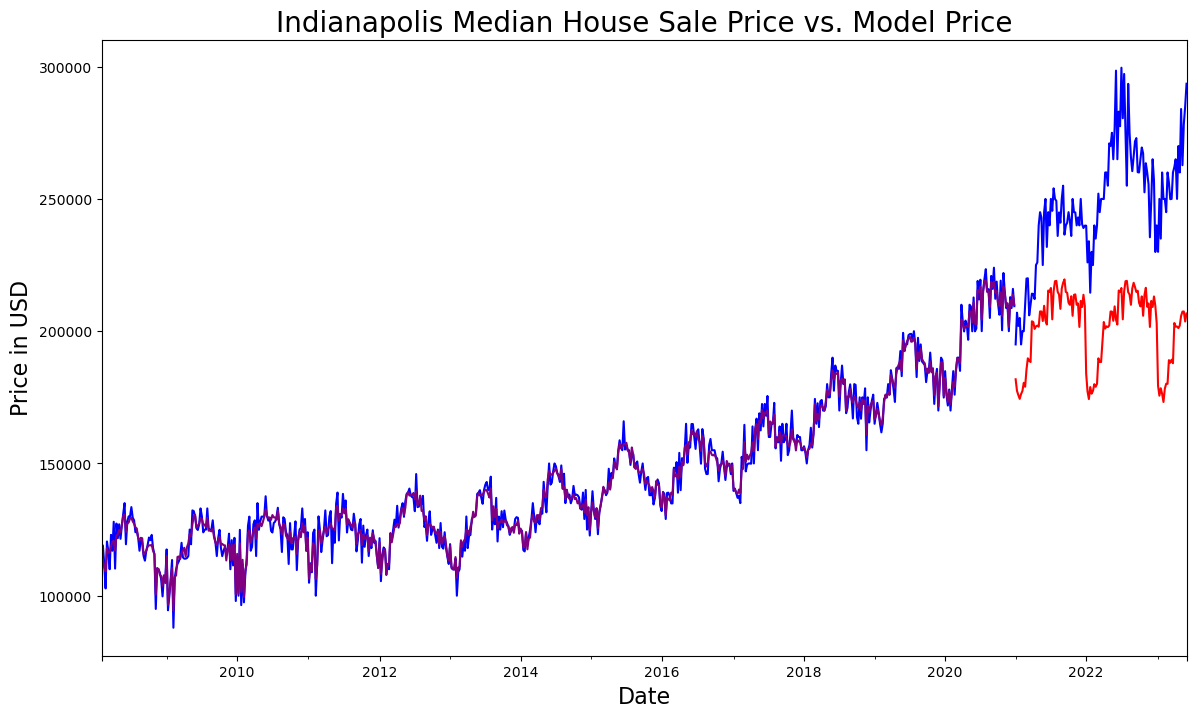

In [29]:
fig, ax = plt.subplots(figsize = (14,8))

indy_train['Price'].plot(color = 'blue')
indy_train['Predicted'].plot(color = 'purple')

indy_test['Price'].plot(color = 'blue')
indy_test['Predicted'].plot(color = 'red')


ax.set_title('Indianapolis Median House Sale Price vs. Model Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

In [30]:
indy_train = indy.loc[indy.index < '2018-01-01']
indy_test = indy.loc[(indy.index >= '2018-01-01') & (indy.index < '2020-01-01')]

In [31]:
X_train_indy = indy_train[features]
y_train_indy = indy_train['Price']

X_test_indy = indy_test[features]
y_test_indy = indy_test['Price']

In [32]:
reg_indy = xgb.XGBRegressor(n_estimators=1000, learning_rate = .01)
reg_indy.fit(X_train_indy, y_train_indy,
        eval_set=[(X_train_indy, y_train_indy), (X_test_indy, y_test_indy)],
        early_stopping_rounds=100,
       verbose=True)

[0]	validation_0-rmse:131976.54283	validation_1-rmse:176697.82186
[1]	validation_0-rmse:130670.57518	validation_1-rmse:175219.72289
[2]	validation_0-rmse:129377.69970	validation_1-rmse:173756.38007
[3]	validation_0-rmse:128097.77910	validation_1-rmse:172307.62147
[4]	validation_0-rmse:126830.68732	validation_1-rmse:170873.30618
[5]	validation_0-rmse:125576.30641	validation_1-rmse:169453.30922
[6]	validation_0-rmse:124334.49108	validation_1-rmse:168080.39793
[7]	validation_0-rmse:123105.09552	validation_1-rmse:166688.24047
[8]	validation_0-rmse:121888.04008	validation_1-rmse:165342.37048
[9]	validation_0-rmse:120683.15047	validation_1-rmse:163977.53698
[10]	validation_0-rmse:119490.35132	validation_1-rmse:162658.16285
[11]	validation_0-rmse:118309.48693	validation_1-rmse:161320.10655
[12]	validation_0-rmse:117140.47263	validation_1-rmse:159995.40110
[13]	validation_0-rmse:115983.16019	validation_1-rmse:158714.68391
[14]	validation_0-rmse:114837.46103	validation_1-rmse:157415.99073
[15]	

[125]	validation_0-rmse:38634.49194	validation_1-rmse:70195.42598
[126]	validation_0-rmse:38263.20015	validation_1-rmse:69748.61623
[127]	validation_0-rmse:37895.74075	validation_1-rmse:69275.98514
[128]	validation_0-rmse:37531.70402	validation_1-rmse:68856.05631
[129]	validation_0-rmse:37171.32567	validation_1-rmse:68422.16728
[130]	validation_0-rmse:36814.70391	validation_1-rmse:67992.58695
[131]	validation_0-rmse:36461.69919	validation_1-rmse:67537.34081
[132]	validation_0-rmse:36112.07412	validation_1-rmse:67086.62842
[133]	validation_0-rmse:35766.06419	validation_1-rmse:66670.13732
[134]	validation_0-rmse:35423.64698	validation_1-rmse:66228.02193
[135]	validation_0-rmse:35084.46755	validation_1-rmse:65790.30605
[136]	validation_0-rmse:34748.58746	validation_1-rmse:65385.91584
[137]	validation_0-rmse:34416.43119	validation_1-rmse:64999.88667
[138]	validation_0-rmse:34087.29836	validation_1-rmse:64602.75263
[139]	validation_0-rmse:33761.67640	validation_1-rmse:64181.13172
[140]	vali

/Users/eitan/anaconda3/envs/Number41/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[167]	validation_0-rmse:25858.63783	validation_1-rmse:54226.86418
[168]	validation_0-rmse:25616.24726	validation_1-rmse:53910.39021
[169]	validation_0-rmse:25375.64440	validation_1-rmse:53597.06249
[170]	validation_0-rmse:25138.08798	validation_1-rmse:53288.20183
[171]	validation_0-rmse:24902.59504	validation_1-rmse:53001.95188
[172]	validation_0-rmse:24669.22682	validation_1-rmse:52697.59724
[173]	validation_0-rmse:24438.51858	validation_1-rmse:52416.96887
[174]	validation_0-rmse:24210.35670	validation_1-rmse:52117.29828
[175]	validation_0-rmse:23984.71162	validation_1-rmse:51821.70654
[176]	validation_0-rmse:23761.01716	validation_1-rmse:51549.27654
[177]	validation_0-rmse:23539.36101	validation_1-rmse:51291.37289
[178]	validation_0-rmse:23320.23309	validation_1-rmse:51024.23347
[179]	validation_0-rmse:23103.34717	validation_1-rmse:50759.77176
[180]	validation_0-rmse:22888.41760	validation_1-rmse:50477.54708
[181]	validation_0-rmse:22675.76777	validation_1-rmse:50218.28202
[182]	vali

[292]	validation_0-rmse:8741.71897	validation_1-rmse:31759.15389
[293]	validation_0-rmse:8676.69002	validation_1-rmse:31671.57555
[294]	validation_0-rmse:8613.12363	validation_1-rmse:31578.35446
[295]	validation_0-rmse:8549.63507	validation_1-rmse:31486.00240
[296]	validation_0-rmse:8487.47552	validation_1-rmse:31394.56487
[297]	validation_0-rmse:8425.44063	validation_1-rmse:31304.18228
[298]	validation_0-rmse:8364.00632	validation_1-rmse:31220.67413
[299]	validation_0-rmse:8303.76248	validation_1-rmse:31131.78786
[300]	validation_0-rmse:8244.50873	validation_1-rmse:31043.76741
[301]	validation_0-rmse:8185.13307	validation_1-rmse:30956.95759
[302]	validation_0-rmse:8126.97000	validation_1-rmse:30870.61240
[303]	validation_0-rmse:8068.94465	validation_1-rmse:30791.31809
[304]	validation_0-rmse:8012.38926	validation_1-rmse:30707.24592
[305]	validation_0-rmse:7956.75211	validation_1-rmse:30623.68077
[306]	validation_0-rmse:7900.58394	validation_1-rmse:30541.22327
[307]	validation_0-rmse:7

[419]	validation_0-rmse:4487.29998	validation_1-rmse:25114.59336
[420]	validation_0-rmse:4473.56557	validation_1-rmse:25088.09205
[421]	validation_0-rmse:4460.36077	validation_1-rmse:25062.97491
[422]	validation_0-rmse:4447.61918	validation_1-rmse:25037.13519
[423]	validation_0-rmse:4434.81309	validation_1-rmse:25011.53704
[424]	validation_0-rmse:4422.13779	validation_1-rmse:24987.09281
[425]	validation_0-rmse:4409.78457	validation_1-rmse:24961.95024
[426]	validation_0-rmse:4397.71567	validation_1-rmse:24937.04142
[427]	validation_0-rmse:4385.75923	validation_1-rmse:24912.81588
[428]	validation_0-rmse:4374.06445	validation_1-rmse:24888.96920
[429]	validation_0-rmse:4362.34891	validation_1-rmse:24865.50966
[430]	validation_0-rmse:4350.67227	validation_1-rmse:24842.26475
[431]	validation_0-rmse:4339.46467	validation_1-rmse:24818.67652
[432]	validation_0-rmse:4327.77710	validation_1-rmse:24795.48563
[433]	validation_0-rmse:4316.62188	validation_1-rmse:24770.81418
[434]	validation_0-rmse:4

[546]	validation_0-rmse:3621.83245	validation_1-rmse:23119.05861
[547]	validation_0-rmse:3618.64669	validation_1-rmse:23110.20038
[548]	validation_0-rmse:3615.02774	validation_1-rmse:23101.98812
[549]	validation_0-rmse:3611.44471	validation_1-rmse:23093.85312
[550]	validation_0-rmse:3608.51790	validation_1-rmse:23085.21549
[551]	validation_0-rmse:3605.04727	validation_1-rmse:23076.60886
[552]	validation_0-rmse:3602.77304	validation_1-rmse:23068.12114
[553]	validation_0-rmse:3599.30568	validation_1-rmse:23060.25755
[554]	validation_0-rmse:3595.91701	validation_1-rmse:23051.92375
[555]	validation_0-rmse:3592.51494	validation_1-rmse:23044.25798
[556]	validation_0-rmse:3589.74093	validation_1-rmse:23036.01862
[557]	validation_0-rmse:3586.43821	validation_1-rmse:23027.89944
[558]	validation_0-rmse:3584.30404	validation_1-rmse:23019.81977
[559]	validation_0-rmse:3581.02676	validation_1-rmse:23012.40816
[560]	validation_0-rmse:3577.80723	validation_1-rmse:23004.49066
[561]	validation_0-rmse:3

[673]	validation_0-rmse:3261.43017	validation_1-rmse:22535.90644
[674]	validation_0-rmse:3260.02558	validation_1-rmse:22533.79308
[675]	validation_0-rmse:3257.77938	validation_1-rmse:22532.28137
[676]	validation_0-rmse:3255.74265	validation_1-rmse:22530.60809
[677]	validation_0-rmse:3252.51715	validation_1-rmse:22527.82093
[678]	validation_0-rmse:3250.31854	validation_1-rmse:22526.37878
[679]	validation_0-rmse:3248.41123	validation_1-rmse:22524.98157
[680]	validation_0-rmse:3246.26070	validation_1-rmse:22523.53812
[681]	validation_0-rmse:3243.11562	validation_1-rmse:22521.96334
[682]	validation_0-rmse:3241.17019	validation_1-rmse:22520.38063
[683]	validation_0-rmse:3239.11877	validation_1-rmse:22518.99034
[684]	validation_0-rmse:3237.75270	validation_1-rmse:22517.02182
[685]	validation_0-rmse:3233.95483	validation_1-rmse:22515.25934
[686]	validation_0-rmse:3232.10564	validation_1-rmse:22513.71779
[687]	validation_0-rmse:3230.76745	validation_1-rmse:22511.79373
[688]	validation_0-rmse:3

[800]	validation_0-rmse:3011.82654	validation_1-rmse:22371.46876
[801]	validation_0-rmse:3007.71650	validation_1-rmse:22369.31872
[802]	validation_0-rmse:3006.59426	validation_1-rmse:22369.11061
[803]	validation_0-rmse:3005.71497	validation_1-rmse:22368.33795
[804]	validation_0-rmse:3001.66175	validation_1-rmse:22366.21834
[805]	validation_0-rmse:3000.44418	validation_1-rmse:22365.95053
[806]	validation_0-rmse:2999.39159	validation_1-rmse:22364.95885
[807]	validation_0-rmse:2998.52567	validation_1-rmse:22364.17927
[808]	validation_0-rmse:2995.98288	validation_1-rmse:22363.52574
[809]	validation_0-rmse:2994.89927	validation_1-rmse:22363.29560
[810]	validation_0-rmse:2993.78445	validation_1-rmse:22363.11876
[811]	validation_0-rmse:2989.49159	validation_1-rmse:22361.76623
[812]	validation_0-rmse:2988.64112	validation_1-rmse:22361.00532
[813]	validation_0-rmse:2987.66433	validation_1-rmse:22358.83328
[814]	validation_0-rmse:2985.22312	validation_1-rmse:22359.04963
[815]	validation_0-rmse:2

[927]	validation_0-rmse:2815.84233	validation_1-rmse:22285.83583
[928]	validation_0-rmse:2815.14449	validation_1-rmse:22285.75830
[929]	validation_0-rmse:2814.52758	validation_1-rmse:22285.42173
[930]	validation_0-rmse:2813.88987	validation_1-rmse:22285.31182
[931]	validation_0-rmse:2813.05104	validation_1-rmse:22285.15877
[932]	validation_0-rmse:2811.20822	validation_1-rmse:22285.18707
[933]	validation_0-rmse:2810.60307	validation_1-rmse:22284.19184
[934]	validation_0-rmse:2808.49526	validation_1-rmse:22283.82485
[935]	validation_0-rmse:2807.77364	validation_1-rmse:22283.89255
[936]	validation_0-rmse:2806.82549	validation_1-rmse:22284.03359
[937]	validation_0-rmse:2805.02281	validation_1-rmse:22283.98456
[938]	validation_0-rmse:2802.14355	validation_1-rmse:22284.28954
[939]	validation_0-rmse:2801.43996	validation_1-rmse:22284.37921
[940]	validation_0-rmse:2799.62022	validation_1-rmse:22284.42204
[941]	validation_0-rmse:2799.02398	validation_1-rmse:22283.45441
[942]	validation_0-rmse:2

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [33]:
indy_train['Predicted'] = reg_indy.predict(X_train_indy)
indy_test['Predicted'] = reg_indy.predict(X_test_indy)

/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1513/3369512537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indy_train['Predicted'] = reg_indy.predict(X_train_indy)
/var/folders/d9/xswmylg9377__r4x6b40670h0000gn/T/ipykernel_1513/3369512537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indy_test['Predicted'] = reg_indy.predict(X_test_indy)


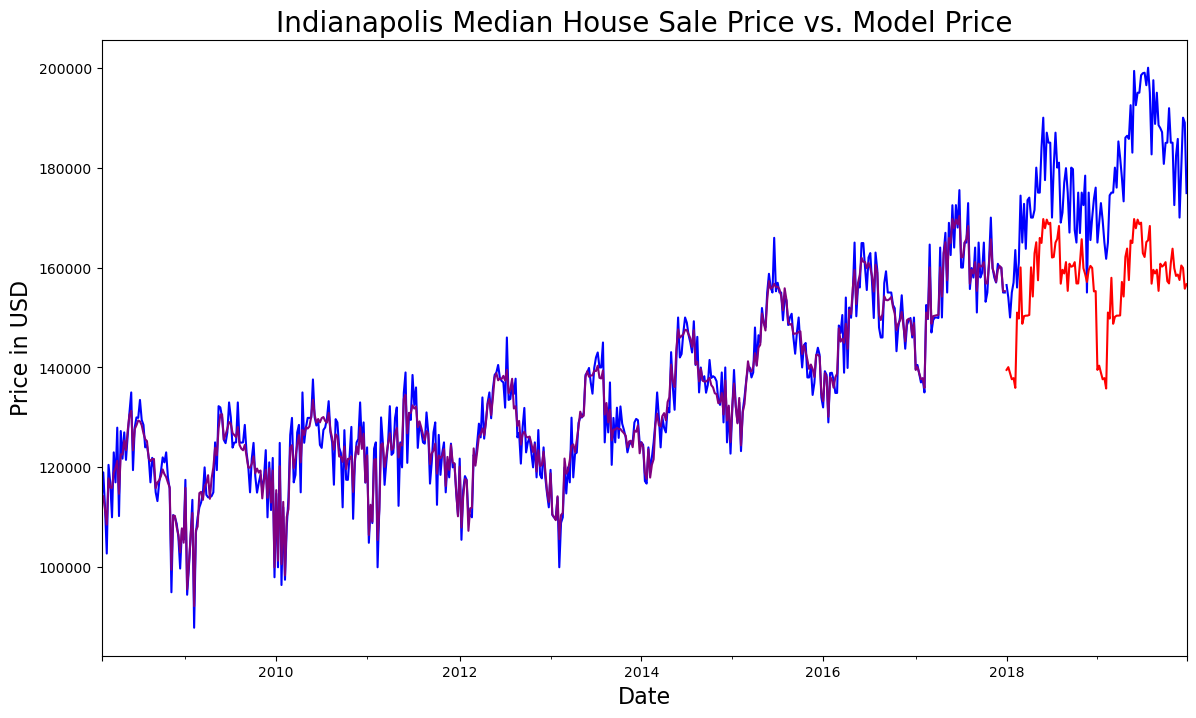

In [35]:
fig, ax = plt.subplots(figsize = (14,8))

indy_train['Price'].plot(color = 'blue')
indy_train['Predicted'].plot(color = 'purple')

indy_test['Price'].plot(color = 'blue')
indy_test['Predicted'].plot(color = 'red')


ax.set_title('Indianapolis Median House Sale Price vs. Model Price', fontsize = 20)

ax.set_xlabel('Date', fontsize = 16);
ax.set_ylabel('Price in USD', fontsize = 16)

plt.show();

In [31]:
X_train_nash = nash_train[features]
y_train_nash = nash_train['Price']

X_test_nash = nash_test[features]
y_test_nash = nash_test['Price']